### Calculate multidimensional disentanglement metric

#### imports and functions

In [1]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from sklearn import svm
import itertools

from scipy.stats import spearmanr

In [2]:
from disentanglement_lib.data.ground_truth import named_data
# manualdsprites = named_data.get_named_ground_truth_data('manual_dsprites', -1)
# dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)
# smallnorb = named_data.get_named_ground_truth_data('smallnorb', -1)
mpi3d = named_data.get_named_ground_truth_data('mpi3d_toy', -1)
cars = named_data.get_named_ground_truth_data('cars3d', -1)
shapes3d = named_data.get_named_ground_truth_data('shapes3d', -1)

In [33]:
dataset_embedding_dimensions = {
    "manual_dsprites": (1, 1, 2, 1, 1),
    "mpi3d_toy": (2, 2, 1, 1, 1, 1, 1),
    "cars3d": (1, 2, 3),
    "shapes3d": (2, 2, 2, 1, 2, 1),
}
dataset_supervised_loss = {
    "mpi3d_toy": ("multidimensional_embed", "multidimensional_embed", "xent", "xent", "xent", "xent", "xent"),
    "cars3d": ("xent", "multidimensional_embed", "multidimensional_embed"),
    "shapes3d": ("multidimensional_embed", "multidimensional_embed", "multidimensional_embed",
        "xent", "multidimensional_embed", "xent"),
}


In [34]:
def calculate_multidimensional_sap(
    dataset,
    num_training_points,
    num_testing_points,
    model_artifact_dir,
):
    # use same set of indices for all mig calculation
    all_indices = np.random.choice(
        len(dataset.images),
        num_training_points + num_testing_points,
        replace=False)
    factors = dataset.index_to_factors(all_indices).T

    mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_1.npy")
    mus = np.load(mean_file_path)
    mus_train = mus[all_indices[:num_training_points], :].T
    mus_test = mus[all_indices[num_training_points:], :].T
    factors_train = factors[:, :num_training_points]
    factors_test = factors[:, num_training_points:]
    scores_each_factor = compute_sap_score(
        mus_train,
        factors_train,
        mus_test,
        factors_test,
        max_latent_dims=2
    )
    return scores_each_factor
    
    
def compute_sap_score(mus, ys, mus_test, ys_test, max_latent_dims=1):
    """calculates prediction scores using all possible latent unit combinations."""
    num_latents = mus.shape[0]
    num_factors = ys.shape[0]
    scores_each_factor = []
    
    for factor in range(num_factors):
        scores = []
        for dims in range(1, max_latent_dims + 1):
            latent_indices = list(itertools.combinations(list(range(num_latents)), dims))
            # print(latent_indices)
            for latent_idx in latent_indices:
                classifier = svm.LinearSVC(C=0.01, class_weight="balanced")
                classifier.fit(mus[latent_idx, :].T, ys[factor, :].T)
                pred = classifier.predict(mus_test[latent_idx, :].T)
                scores.append(np.mean(pred == ys_test[factor, :].T))
        scores_each_factor.append(scores)
    return scores_each_factor

#### calculate multidimensional SAP score

In [36]:
dataset = mpi3d
num_training_points=10000
num_testing_points=5000
exp_idx = 4
model_idx = 0

num_latents = 10
classifier_latent_indices = list(itertools.combinations(list(range(num_latents)), 1)) \
    + list(itertools.combinations(list(range(num_latents)), 2))

model_artifact_dir=os.path.join(
    "/home/mwu34/disentanglement_lib/",
    f"output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts/"
)

results = calculate_multidimensional_sap(
    dataset,
    num_training_points=10000,
    num_testing_points=5000,
    model_artifact_dir=model_artifact_dir,
)

/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/minicond

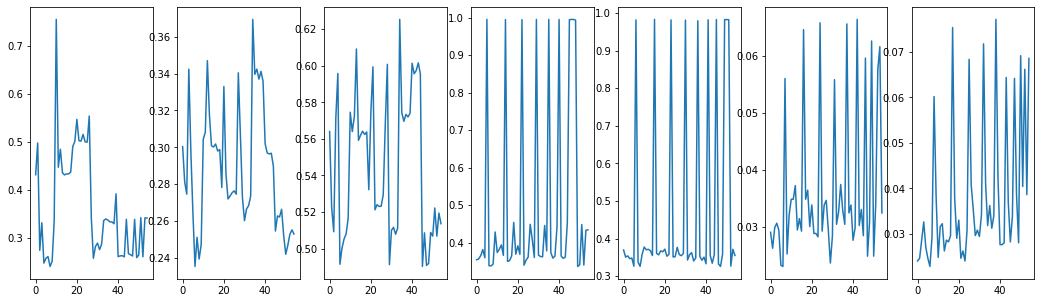

In [37]:
fig, axs = plt.subplots(1, len(results), figsize=(18, 5))
for i in range(len(results)):
    axs[i].plot(results[i])

In [59]:
# for each factor, find 6 values
# [highest, second-highest, diff] for 1 units
# [highest, non-overlapping second-highest, diff] for 2 units
sap_results = np.zeros((len(results), 6))
for factor in range(len(results)):
    one_factor_results = sorted(results[factor][:10], reverse=True)
    sap_results[factor, 0] = one_factor_results[0]
    sap_results[factor, 1] = one_factor_results[1]
    sap_results[factor, 2] = one_factor_results[0] - one_factor_results[1]
    
    two_unit_results = np.argsort(results[factor][10:])[::-1]
    best_pair = set(classifier_latent_indices[10 + two_unit_results[0]])
    sap_results[factor, 3] = results[factor][10 + two_unit_results[0]]
    for i in range(1, len(two_unit_results)):
        candidate_pair = set(classifier_latent_indices[10 + two_unit_results[i]])
        if not best_pair.intersection(set(candidate_pair)):
            sap_results[factor, 4] = results[factor][10 + two_unit_results[i]]
            print(best_pair, candidate_pair)
            break
    sap_results[factor, 5] = sap_results[factor, 3] - sap_results[factor, 4]
print(sap_results)

{0, 1} {9, 3}
{3, 4} {0, 2}
{3, 4} {0, 1}
{3, 5} {0, 9}
{0, 6} {1, 9}
{4, 7} {0, 3}
{8, 3} {9, 2}
[[0.498 0.432 0.066 0.756 0.392 0.364]
 [0.342 0.3   0.042 0.369 0.308 0.061]
 [0.596 0.571 0.025 0.625 0.575 0.051]
 [0.996 0.428 0.568 0.996 0.454 0.542]
 [0.982 0.37  0.612 0.983 0.377 0.606]
 [0.056 0.032 0.024 0.066 0.037 0.029]
 [0.06  0.038 0.022 0.077 0.041 0.036]]


#### visualize loss between labelled data points and embedding values

In [24]:
def calculate_embeddings(exp_idx, model_idx, num_embeddings, axs=None):
    """plot out the visualization of each embedding value for each factor."""
    folder_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/'
    hub_path = os.path.join(folder_path, f"{model_idx}/model/tfhub")
    checkpoint_path = os.path.join(folder_path, f"{model_idx}/model/tf_checkpoint")
    variable_list = [var for var, shape in tf.train.list_variables(checkpoint_path)]

    # fig, axs = plt.subplots(1, num_embeddings, figsize=(18, 5))
    # by default loads the latest checkpoint
    embeddings = []
    for idx in range(num_embeddings):
        var_name = f'supervised_loss/{idx}/embedding'
        if var_name in variable_list:
            embedding = tf.train.load_variable(checkpoint_path, var_name)
            embeddings.append(embedding)
            if axs:
                ax = axs[idx]
                if embedding.shape[1] == 1:
                    ax.plot(embedding[:, 0])
                elif embedding.shape[1] == 2:
                    ax.scatter(embedding[:, 0], embedding[:, 1], c = range(len(embedding)), cmap='cool')
                else:
                    raise ValueError("can't show embedding with > 2 dimensions.")
    return embeddings


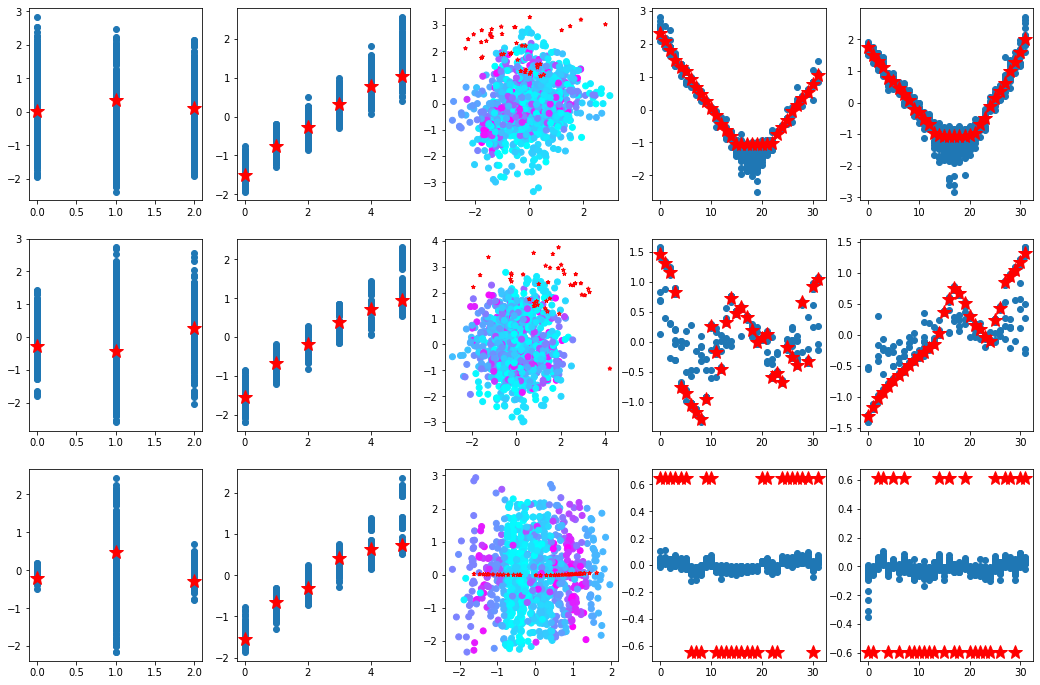

In [97]:
# works in exp 3, where all results are on the same dataset

exp_idx = 3
dataset = manualdsprites
model_indices = [15, 16, 17]
num_embeddings = 5
embedding_dimensions = [1,1,2,1,1]

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(embedding[emb_idx]))), embedding[emb_idx][:, 0], 'r*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / 40
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                embedding[emb_idx][:, 0],
                embedding[emb_idx][:, 1],
                c = np.linspace(0, 1, 40),
                marker = '*',
                edgecolors = 'r',
                s = 15,
                cmap='cool'
            )
            latent_idx += 2
            
    

In [66]:
gg = np.linspace(0, 1, 5)

In [67]:
gg

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [68]:
gg_ten=  tf.convert_to_tensor(gg)

In [69]:
gg_ten.shape

TensorShape([Dimension(5)])

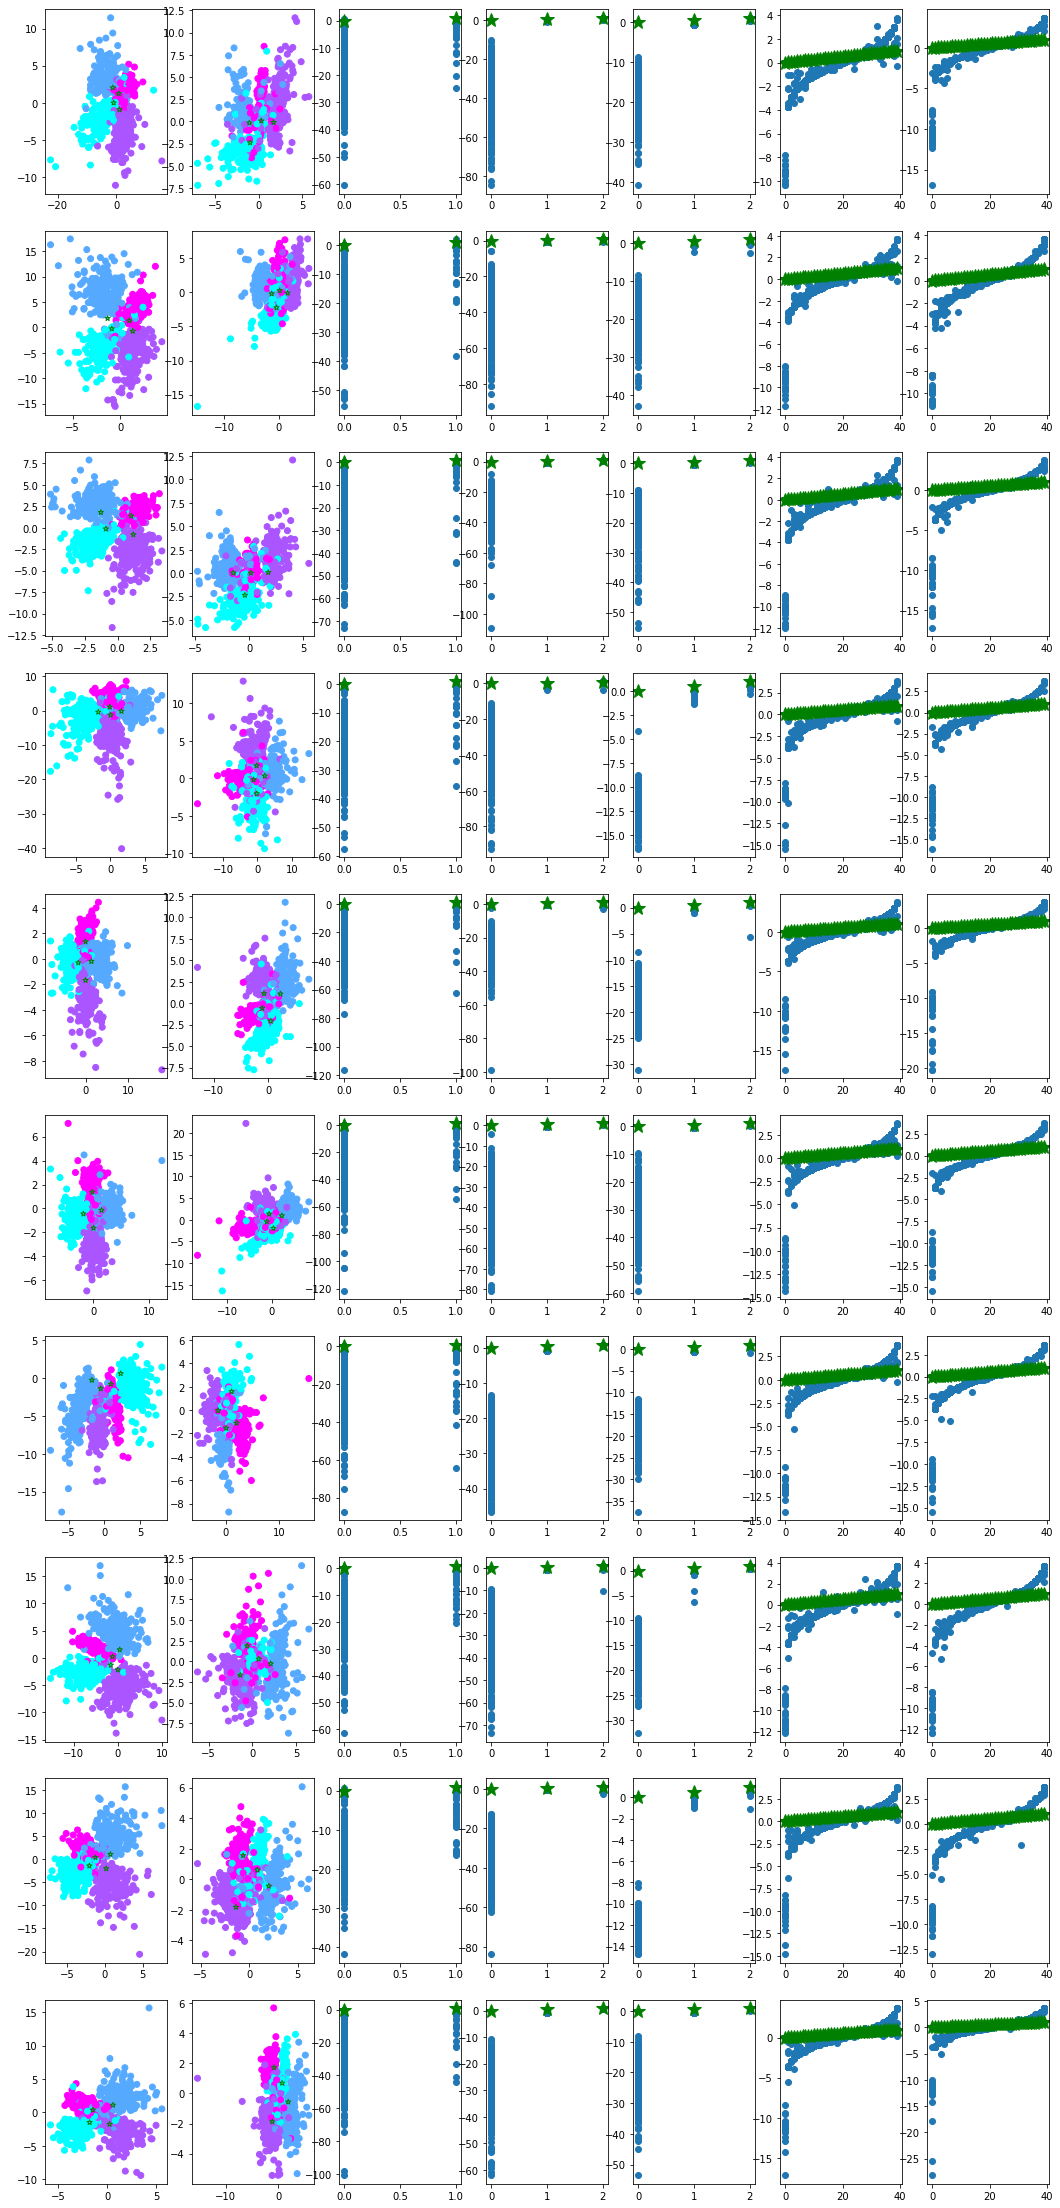

In [29]:
# works on exp v4, use model_name to find results
exp_idx = 4
dataset = mpi3d
dataset_name = 'mpi3d_toy'
dataset_name_in_df = "'mpi3d_toy'"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    learned_embedding_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if loss_terms[emb_idx] == 'multidimensional_embed':
            curr_embedding = embedding[learned_embedding_idx]
            learned_embedding_idx += 1
        else:
            curr_embedding = np.expand_dims(np.linspace(0, 1, dataset.factor_sizes[emb_idx]), axis=1)
        
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding[:, 0], 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

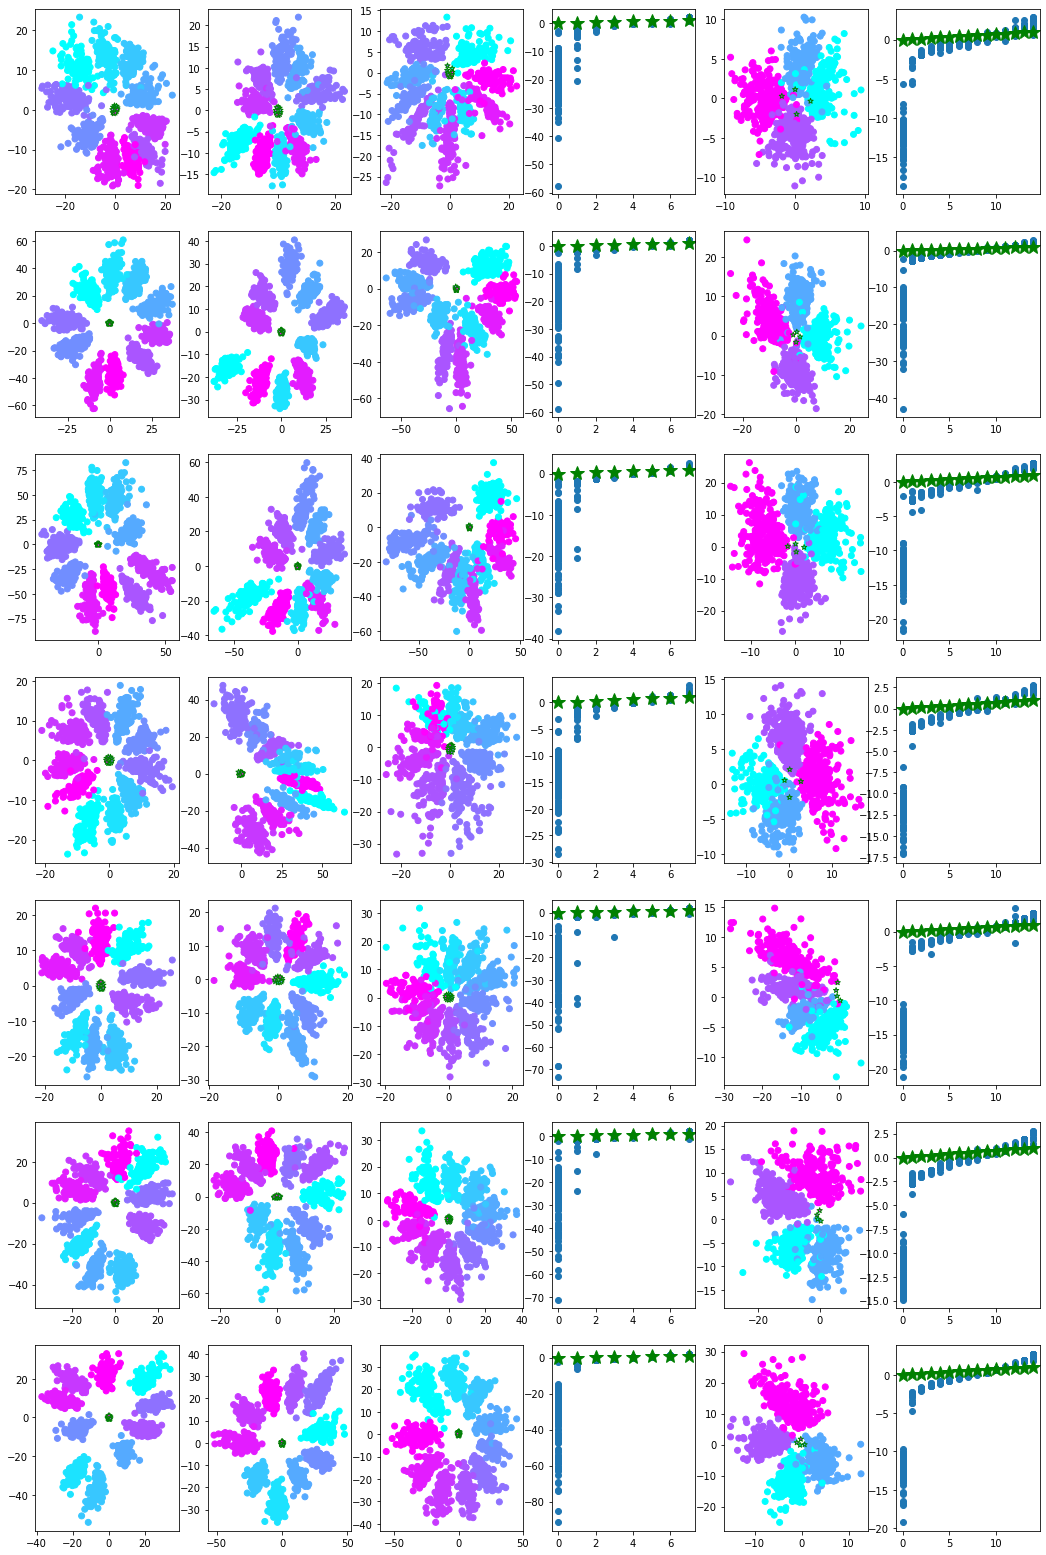

In [30]:
# works on exp v4, use model_name to find results
exp_idx = 4
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    learned_embedding_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if loss_terms[emb_idx] == 'multidimensional_embed':
            curr_embedding = embedding[learned_embedding_idx]
            learned_embedding_idx += 1
        else:
            curr_embedding = np.expand_dims(np.linspace(0, 1, dataset.factor_sizes[emb_idx]), axis=1)
        
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding[:, 0], 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

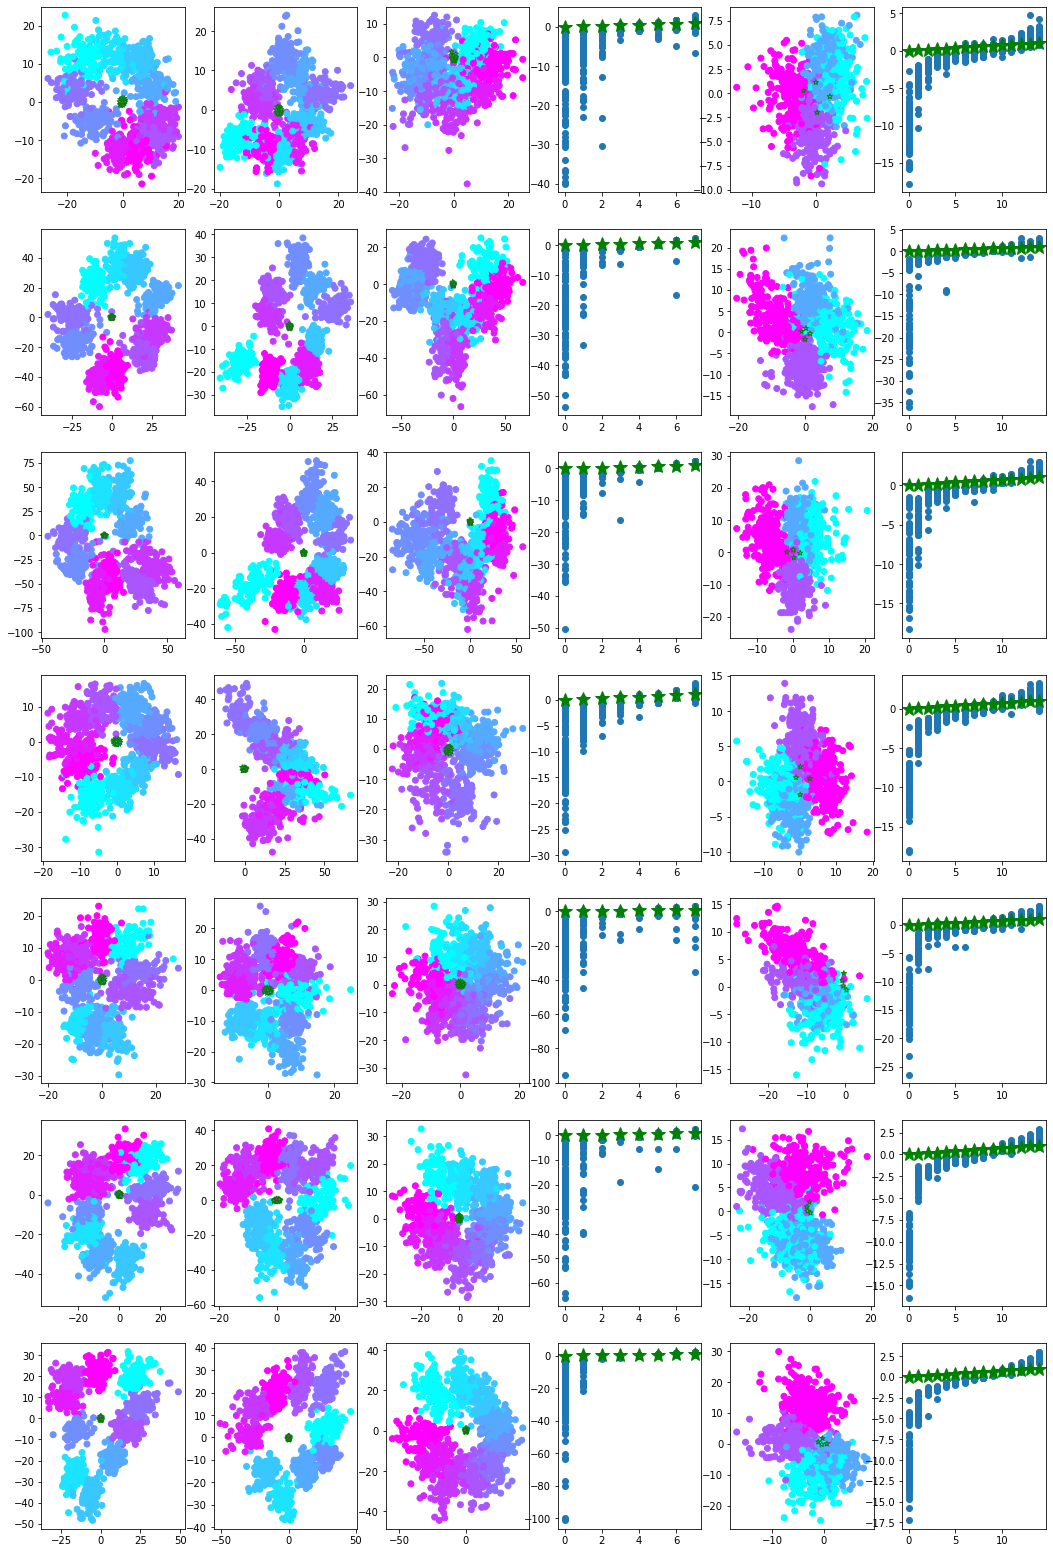

In [32]:
# works on exp v4, use model_name to find results
exp_idx = 4
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.random.choice(len(dataset.images), 1000, replace=False)
    # labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    learned_embedding_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if loss_terms[emb_idx] == 'multidimensional_embed':
            curr_embedding = embedding[learned_embedding_idx]
            learned_embedding_idx += 1
        else:
            curr_embedding = np.expand_dims(np.linspace(0, 1, dataset.factor_sizes[emb_idx]), axis=1)
        
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding[:, 0], 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

In [60]:
dataset = mpi3d
num_training_points=10000
num_testing_points=5000
exp_idx = 16
model_idx = 15

num_latents = 10
classifier_latent_indices = list(itertools.combinations(list(range(num_latents)), 1)) \
    + list(itertools.combinations(list(range(num_latents)), 2))

model_artifact_dir=os.path.join(
    "/home/mwu34/disentanglement_lib/",
    f"output_active_learning_study_v{exp_idx}/{model_idx}/model/artifacts/"
)

results = calculate_multidimensional_sap(
    dataset,
    num_training_points=10000,
    num_testing_points=5000,
    model_artifact_dir=model_artifact_dir,
)

/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/minicond

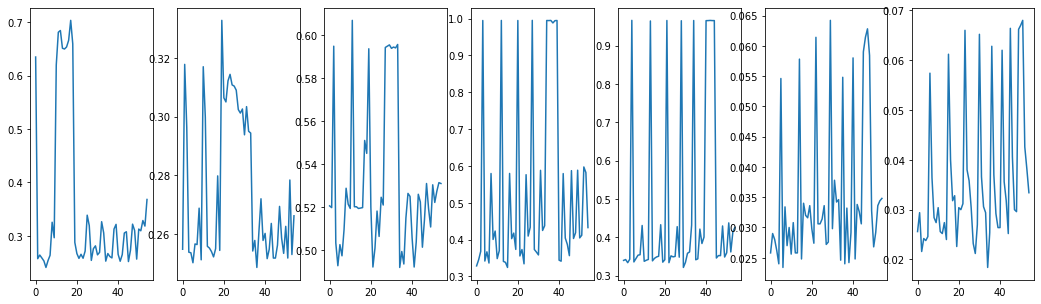

In [61]:
fig, axs = plt.subplots(1, len(results), figsize=(18, 5))
for i in range(len(results)):
    axs[i].plot(results[i])

In [64]:
# for each factor, find 6 values
# [highest, second-highest, diff] for 1 units
# [highest, non-overlapping second-highest, diff] for 2 units
sap_results = np.zeros((len(results), 6))
for factor in range(len(results)):
    one_factor_results = sorted(results[factor][:10], reverse=True)
    sap_results[factor, 0] = one_factor_results[0]
    sap_results[factor, 1] = one_factor_results[1]
    sap_results[factor, 2] = one_factor_results[0] - one_factor_results[1]
    
    two_unit_results = np.argsort(results[factor][10:])[::-1]
    best_pair = set(classifier_latent_indices[10 + two_unit_results[0]])
    sap_results[factor, 3] = results[factor][10 + two_unit_results[0]]
    for i in range(1, len(two_unit_results)):
        candidate_pair = set(classifier_latent_indices[10 + two_unit_results[i]])
        if not best_pair.intersection(set(candidate_pair)):
            sap_results[factor, 4] = results[factor][10 + two_unit_results[i]]
            print(best_pair, candidate_pair)
            break
    sap_results[factor, 5] = sap_results[factor, 3] - sap_results[factor, 4]
print(sap_results)

{0, 8} {9, 3}
{1, 2} {0, 8}
{0, 2} {9, 7}
{2, 3} {8, 7}
{4, 7} {9, 6}
{2, 5} {8, 9}
{9, 6} {8, 7}
[[0.635 0.325 0.309 0.703 0.321 0.382]
 [0.318 0.296 0.021 0.333 0.28  0.053]
 [0.595 0.529 0.066 0.607 0.531 0.075]
 [0.995 0.579 0.415 0.995 0.597 0.398]
 [0.966 0.431 0.535 0.965 0.437 0.528]
 [0.055 0.033 0.021 0.064 0.035 0.029]
 [0.057 0.036 0.021 0.068 0.043 0.025]]


In [65]:
print(new_sap_results)
print(sap_results)

[[0.498 0.432 0.066 0.756 0.392 0.364]
 [0.342 0.3   0.042 0.369 0.308 0.061]
 [0.596 0.571 0.025 0.625 0.575 0.051]
 [0.996 0.428 0.568 0.996 0.454 0.542]
 [0.982 0.37  0.612 0.983 0.377 0.606]
 [0.056 0.032 0.024 0.066 0.037 0.029]
 [0.06  0.038 0.022 0.077 0.041 0.036]]
[[0.635 0.325 0.309 0.703 0.321 0.382]
 [0.318 0.296 0.021 0.333 0.28  0.053]
 [0.595 0.529 0.066 0.607 0.531 0.075]
 [0.995 0.579 0.415 0.995 0.597 0.398]
 [0.966 0.431 0.535 0.965 0.437 0.528]
 [0.055 0.033 0.021 0.064 0.035 0.029]
 [0.057 0.036 0.021 0.068 0.043 0.025]]
